Alejandro Mariacca Santin
A01654102

In [610]:
%matplotlib inline
import matplotlib.pyplot as ptl

In [611]:
def compute_gini(model):
    agent_points = [agent.puntos for agent in model.schedule.agents]
    x = sorted(agent_points)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B

In [612]:
import mesa
class AspiradoraAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.puntos = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def clean(self):
        cell = self.model.grid.get_cell_list_contents([self.pos])
        # print(cell)
        for element in cell:
            if isinstance(element, TrashAgent) == True:
                self.model.grid.remove_agent(element)
                self.puntos += 1

    def step(self):
        self.move()
        self.clean()


class AspiradoraModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, Basura, width, height):
        self.num_agents = N
        self.basura = Basura

        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.schedule2 = mesa.time.RandomActivation(self)
        self.running = True
        
        for i in range(self.num_agents):
            a = AspiradoraAgent(i, self)
            self.schedule.add(a)
            self.grid.place_agent(a, (1, 1))

        for i in range(self.basura):
            a = TrashAgent(i + self.num_agents, Basura)
            self.schedule2.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))



        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Puntos": "puntos"}
        )
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
    

class TrashAgent(mesa.Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)


(array([  0.,  19.,  40.,  66.,  93., 110.,  72.,  48.,  23.,  20.,   9.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]),
 <BarContainer object of 11 artists>)

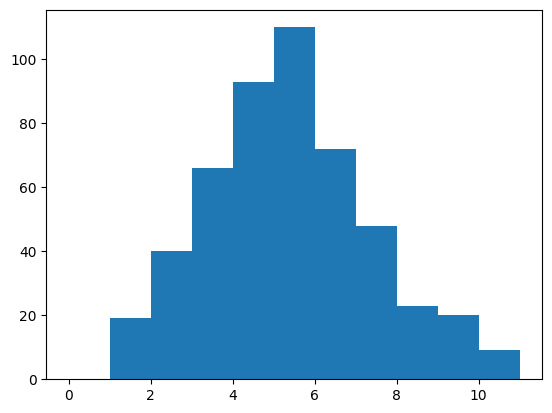

In [613]:
all_wealth = []

# This runs the model 100 times, each model executing 100 steps.
for j in range(100):
    # Run the model
    model = AspiradoraModel(5, 20, 10, 10)
    for i in range(100):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.puntos)

ptl.hist(all_wealth, bins=range(max(all_wealth) + 1))


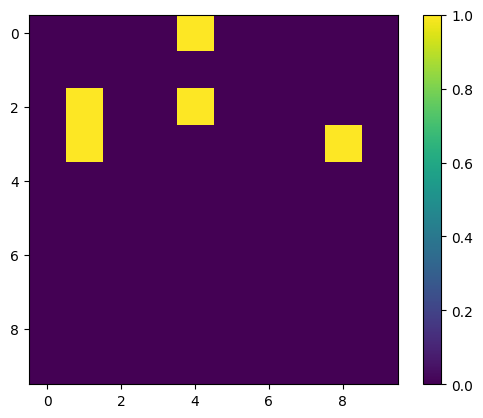

In [614]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
ptl.imshow(agent_counts, interpolation="nearest")
ptl.colorbar()

<AxesSubplot: >

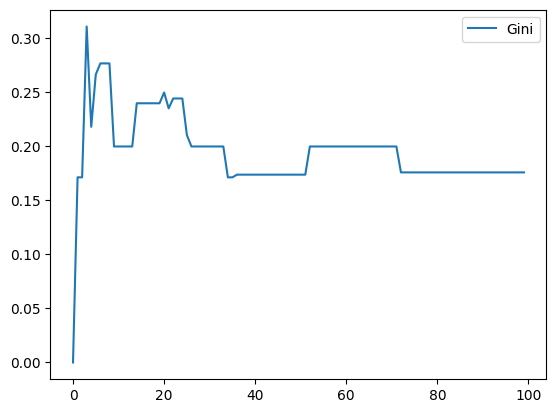

In [615]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [616]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.tail()

Puntos
Step AgentID        
99   0             5
     1             2
     2             5
     3             7
     4             6

In [617]:
params = {"width": 10,  "height": 10, "N": 5,"Basura": 20}
#params = {"width": 10,  "height": 10, "N": range(1, 110, 10),"Basura": 20}
results = mesa.batch_run(
    AspiradoraModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)

100%|██████████| 5/5 [00:00<00:00, 304.08it/s]


In [618]:
import pandas as pd

results_df = pd.DataFrame(results)
print(results_df.keys())

Index(['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Basura', 'Gini',
       'AgentID', 'Puntos'],
      dtype='object')


<AxesSubplot: xlabel='AgentID'>

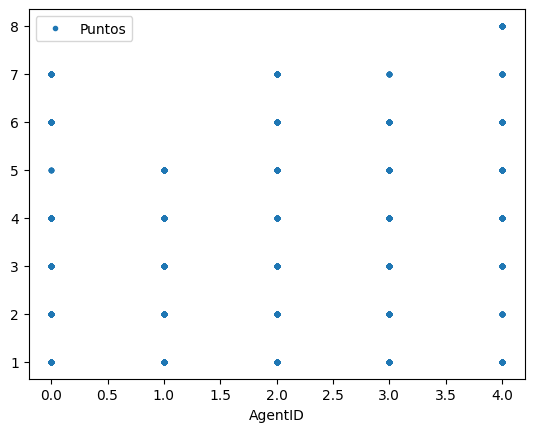

In [619]:
results_df.plot(x='AgentID', y='Puntos', style='.')


<AxesSubplot: xlabel='Step'>

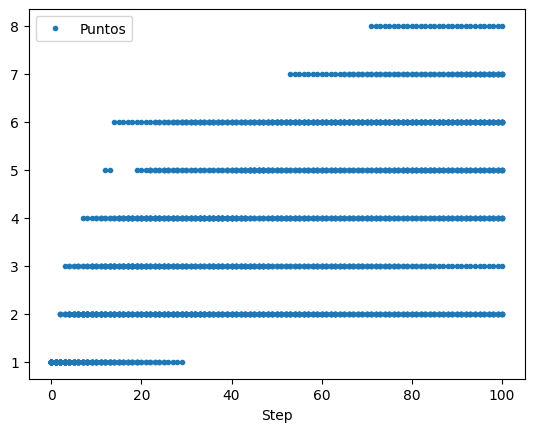

In [620]:
results_df.plot(x='Step', y='Puntos', style='.')

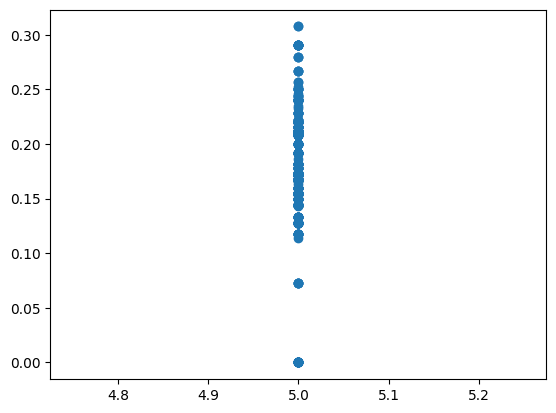

In [621]:
results_filtered = results_df[(results_df.AgentID == 2) & (results_df.Step <= 101)]
N_values = results_filtered.N.values
gini_values = results_filtered.Gini.values
ptl.scatter(N_values, gini_values)

Estas son funciones que representan datos de forma numérica y no en forma de tabla.

In [622]:
# First, we filter the results
one_episode_wealth = results_df#[(results_df.N == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Puntos"], max_rows=25
    )
)

 Step  AgentID  Puntos
    0        0       1
    0        1       1
    0        2       1
    0        3       1
    0        4       1
    1        0       1
    1        1       1
    1        2       1
    1        3       1
    1        4       1
    2        0       2
    2        1       1
  ...      ...     ...
   98        3       4
   98        4       6
   99        0       6
   99        1       2
   99        2       7
   99        3       4
   99        4       6
  100        0       6
  100        1       2
  100        2       7
  100        3       4
  100        4       6


In [623]:
results_one_episode = results_df

print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=25))

 Step     Gini
    0 0.000000
    0 0.000000
    0 0.000000
    0 0.000000
    0 0.000000
    1 0.000000
    1 0.000000
    1 0.000000
    1 0.000000
    1 0.000000
    2 0.133333
    2 0.133333
  ...      ...
   98 0.192000
   98 0.192000
   99 0.192000
   99 0.192000
   99 0.192000
   99 0.192000
   99 0.192000
  100 0.192000
  100 0.192000
  100 0.192000
  100 0.192000
  100 0.192000
